In [2]:
import pandas as pd
import numpy as np
import json
import folium
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as shc

# Getting and cleaning the data

## Correspondance between 2016 and 2020 FSA

The FSA have evolved since the census in 2016. The main part of the FSA is similar, but some of them have changed. So, we will group them in order to have similar territories for the data from 2016 and the data from 2020.

In [3]:
def process_fsa(fsa, year):
    if year == 2020:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4Y': 'H9P', 'H9P': 'H9P',
                'H5B': 'H2Z',
                'H5A': 'H3A-H3B', 'H4Z': 'H3A-H3B',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T', 'H4T': 'H4R-H4S-H4T'}
    if year == 2016:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T'}
    if fsa in fsas:
        return fsas[fsa]
    else:
        return fsa

## Foursquare

In [4]:
# Export the foursquare dataset
foursquare = pd.read_csv('../data/foursquare/all.csv')

# Drop duplicates
foursquare.drop_duplicates(subset = 'id', inplace=True, ignore_index=True)

# Process the data to group categories
def process_categories(category_name):
    
    # Restaurant and Bar
    restaurant = ['restaurant', 'bar', 'café', 'cafe', 'coffee', 'pizza', 'sandwich', 'breakfast spot', 'ice cream',
                  'frozen yogurt', 'speakeasy', 'nightlife', 'diner', 'lounge', 'joint', 'snack', 'bistro', 'food truck',
                  'brewery', 'strip club', 'pub', 'nightclub', 'food court', 'steakhouse', 'tea room', 'taco', 'castle',
                  'creperie', 'buffet', 'food service', 'bath house', 'poke place', 'soup place', 'club house',
                  'fish & chips', 'burrito', 'poutine', 'noodle', 'brasserie', 'well', 'salad place', 'beer garden']
    for r in restaurant:
        if r in str(category_name).lower() and str(category_name) not in ['Salon / Barbershop', 'Piano Bar', 'Public Art']:
            return 'RestaurantBar'
    
    # Entertainment
    entertainment = ['museum', 'theater', 'entertainment', 'event space', 'art gallery', 'performing', 'public art',
                     'art studio', 'library', 'design', 'music venue', 'comedy', 'photography', 'sculpture',
                     'convention center', 'arcade', 'bowling', 'recreation', 'rock', 'jazz', 'concert', 'auditorium',
                     'water', 'monument', 'lighthouse', 'exhibit', 'planetarium', 'recording studio', 'memorial site',
                     'piano', 'circus', 'zoo', 'massage', 'casino', 'play area']
    for e in entertainment:
        if e in str(category_name).lower() and 'college' not in str(category_name).lower() or str(category_name) == 'Spa':
            return 'EntertainmentCulture'
    
    # Services
#     services = ['store', 'shop', 'service', 'pharmacy', 'bank', 'bakery', 'gas station', 'government', 'bodega',
#                 'salon', 'post', 'rental car', 'veterinarian', 'boutique', 'car wash', 'tattoo', 'butcher', 'real estate',
#                 'auto', 'storage', 'market', 'parking', 'atm', 'lawyer', 'funeral', 'food', 'cleaner', 'embassy',
#                 'driving', 'agency', 'courthouse', 'repair', 'winery', 'grocery', 'animal', 'notary', 'food stand',
#                 'credit union', 'locksmith', 'laundromat', 'general travel']
#     for s in services:
#         if s in str(category_name).lower():
#             return 'Services'
    
    # Sports
    sports = ['pool', 'gym', 'sports', 'field', 'studio', 'court', 'rink', 'golf', 'arena', 'track', 'stadium',
              'skate', 'range', 'dojo', 'curling']
    for s in sports:
        if s in str(category_name).lower():
            return 'Sports'
    
    # Outdoor
    outdoor = ['park', 'outdoor', 'scenic lookout', 'site', 'garden', 'marina', 'boat', 'plaza', 'trail', 'mountain', 'surf',
               'campground', 'lake', 'beach', 'rest area', 'vineyard', 'forest', 'nature', 'cave', 'fishing', 'rafting']
    for o in outdoor:
        if o in str(category_name).lower():
            return 'Outdoor'
    
#     # Medical
#     medical = ['dentist', 'doctor', 'medical', 'hospital', 'assisted living', 'chiropractor', 'mental', 'healer',
#                'emergency', 'therapist', 'laboratory', 'acupuncturist', 'clinic']
#     for m in medical:
#         if m in str(category_name).lower():
#             return 'Medical'
    
#     # Religious
#     religious = ['church', 'synagogue', 'temple', 'spiritual', 'mosque', 'shrine']
#     for r in religious:
#         if r in str(category_name).lower():
#             return 'Religious'
    
    # All other
    if pd.isna(category_name):
        category = 'Other'

    return 'Other'

foursquare['Category'] = foursquare['category_name'].apply(process_categories)
# Process the FSA to make correspondance between 2016 and 2020
foursquare['FSA'] = foursquare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by categories to get the number of venues for each category per FSA
foursquare = foursquare[['FSA', 'id', 'Category']].groupby(['FSA', 'Category']).agg(NbVenue=('id','count')).reset_index()
foursquare.head()

FSA              Category  NbVenue
0  H1A  EntertainmentCulture        3
1  H1A                 Other       67
2  H1A               Outdoor       10
3  H1A         RestaurantBar        7
4  H1A                Sports        9

## STM

In [6]:
# Read the CSV file with the metro stations per FSA
metro_stations = pd.read_csv('../data/metro/metro_stations.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
metro_stations['FSA'] = metro_stations['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of stations per FSA
metro_stations = metro_stations.groupby(['FSA']).agg(MetroStations=('Name', 'count')).reset_index()
metro_stations.head()

FSA  MetroStations
0  H1L              1
1  H1N              4
2  H1V              1
3  H1W              3
4  H2A              1

## Daycare

In [7]:
# Get the data from the CSV file
daycare = pd.read_csv('../data/daycare/liste-des-services-de-garde-07.csv', engine='python')

# Keep only the daycares in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
daycare = daycare[daycare['CODE_POSTAL_COMPO'].apply(mtl_fsa)].reset_index(drop=True)
daycare['FSA'] = daycare['CODE_POSTAL_COMPO'].apply(lambda x: x[0:3])

# Process the FSA to make correspondance between 2016 and 2020
daycare['FSA'] = daycare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of daycares per FSA
daycare = daycare.groupby(['FSA']).agg(Daycare=('ADRESSE','count')).reset_index()
daycare.head()

FSA  Daycare
0  H1A       14
1  H1B       10
2  H1C        8
3  H1E       28
4  H1G       26

## Schools

In [8]:
# Get the data from the CSV files
college = pd.read_csv('../data/schools/ES_Collegial.csv', sep=';')
univ = pd.read_csv('../data/schools/ES_Universitaire.csv', sep=';')
pps_gouv = pd.read_csv('../data/schools/PPS_Gouvernemental.csv', sep=';')
pps_prive = pd.read_csv('../data/schools/PPS_Prive_Installation.csv', sep=';')
pps_public = pd.read_csv('../data/schools/PPS_Public_Ecole.csv', sep=';')
pps_public.rename(columns={'CD_POSTL_GDUNO_ORGNS': 'CD_POSTL_GDUNO'}, inplace=True)

# Keep only the schools in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
college = college[college['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
univ = univ[univ['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_gouv = pps_gouv[pps_gouv['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_prive = pps_prive[pps_prive['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_public = pps_public[pps_public['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)

# Duplicate rows with multiple school levels and separate the name to have one row for one school level
def school_level(school):
    for i in school.index:
        s = school.loc[i, 'ORDRE_ENS'].split('-')
        if len(s) > 1:
            for j in range(1, len(s)):
                m = max(school.index)+1
                school.loc[m] = school.loc[i]
                school.loc[m, 'ORDRE_ENS'] = s[j]
                if school.loc[m, 'ORDRE_ENS'][0] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][1:]
                if school.loc[m, 'ORDRE_ENS'][-1] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][:-1]
            school.loc[i, 'ORDRE_ENS'] = s[0]
            school.loc[i, 'ORDRE_ENS'] = school.loc[i, 'ORDRE_ENS'][:-1]
    school.sort_values(by=['OBJECTID'], inplace=True)
    school.reset_index(drop=True, inplace=True)
    return school
pps_prive = school_level(pps_prive)
pps_public = school_level(pps_public)

# Create a dataframe containing all the schools with the FSA and the school level
schools = pd.concat([college[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     univ[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_gouv[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_prive[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_public[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']]])
schools['CD_POSTL_GDUNO'] = schools['CD_POSTL_GDUNO'].apply(lambda x: x[0:3])
schools.rename(columns={'OBJECTID': 'SchoolId', 'CD_POSTL_GDUNO': 'FSA', 'ORDRE_ENS': 'Level'}, inplace=True)

# Classify the school level into three categories: PPS (Preschool, Primary school and Secondary school),
# Post-secondary and Professional Formation - Adult Education
def classify_school_levels(level):
    if level in ['Préscolaire', 'Primaire', 'Secondaire']:
        return 'PPS'
    if level in ['Collégial', 'Universitaire']:
        return 'PostSecondary'
    if level in ['Éducation aux adultes', 'Formation professionnelle']:
        return 'ProfessionalFormation-AdultEducation'
schools['SchoolType'] = schools['Level'].apply(classify_school_levels)
schools.sort_values(by=['FSA'], inplace=True)

# Process the FSA to make correspondance between 2016 and 2020
schools['FSA'] = schools['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of schools (for each category) per FSA
schools = schools.groupby(['FSA', 'SchoolType']).agg(NbSchool=('SchoolId','count')).reset_index()
schools.head()

FSA                            SchoolType  NbSchool
0  H1A                                   PPS        23
1  H1B                                   PPS        16
2  H1B  ProfessionalFormation-AdultEducation         6
3  H1C                                   PPS        14
4  H1E                                   PPS        15

## Walkscore

Let's see all the available and not available walkscores, transitscores and bikescores on the map.

In [9]:
# Data for Montreal
latitude = 45.535433
longitude = -73.636493
mtl_geo_json = "../data/maps/mtl_fsa_map.geojson"
mtl_grp_geo_json = "../data/maps/mtl_fsa_grouped_map.geojson"

# Get the walkscore data
ws = pd.read_csv('../data/walkscore/walkscore.csv', index_col=0)

# Choose the score to visualize
score = 'Walkscore' # 'Walkscore' or 'Transitscore' or 'Bikescore'

# Built the map
nan_ws_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(nan_ws_map)
for lat, lng, score in zip(ws['Latitude'], ws['Longitude'], ws[score]):
    label = folium.Popup(str(score), parse_html=True)
    if np.isnan(score):
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='red',
            parse_html=False).add_to(nan_ws_map)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='blue',
            parse_html=False).add_to(nan_ws_map)
nan_ws_map

The available walkscores and bikescores can be processed but the transitscores are not relevant because they are too concentrated on a single geographic area.

In [10]:
# Process the FSA to make correspondance between 2016 and 2020
ws['FSA'] = ws['FSA'].apply(lambda x: process_fsa(x, 2016))
# Get the mean score for each FSA
walkscore = ws.groupby('FSA', as_index=False).mean()
# Drop the transitscore because it is not relevant
walkscore.drop(columns='Transitscore', inplace=True)

# # Get the description associated with the score
# def score_description(score, score_type):
#     description = {'Walkscore': ['Car-dependent+', 'Car-dependent', 'SomewhatWalkable',
#                                   'VeryWalkable', 'WalkersParadise'],
#                     'Bikescore': ['SomewhatBikeable', 'SomewhatBikeable', 'Bikeable',
#                                   'VeryBikeable', 'BikersParadise']}
#     if score < 25:
#         return description[score_type][0]
#     if score >= 25 and score < 50:
#         return description[score_type][1]
#     if score >= 50 and score < 70:
#         return description[score_type][2]
#     if score >= 70 and score < 90:
#         return description[score_type][3]
#     if score >= 90 and score <= 100:
#         return description[score_type][4]

# walkscore.rename(columns={'Walkscore': 'WalkscoreValue',
#                           'Bikescore': 'BikescoreValue'}, inplace=True)
# score_types = ['Walkscore', 'Bikescore']
# for score_type in score_types:
#     walkscore[score_type] = walkscore[score_type + 'Value'].apply(lambda x: score_description(x, score_type))
walkscore.head()

FSA   Latitude  Longitude  Walkscore  Bikescore
0  H1A  45.670741 -73.505878  19.733766  54.967532
1  H1B  45.635377 -73.523538  15.466165  47.318182
2  H1C  45.669124 -73.534936   3.850877  47.157895
3  H1E  45.638857 -73.583131  31.719298  54.719298
4  H1G  45.612047 -73.620212  49.437500  60.137500

Let's see the choropleth map of Montreal for the walkscores and bikescores:

In [11]:
score = 'Walkscore' # 'Walkscore' or 'Bikescore'
bins = {'Walkscore': [0, 25, 50, 70, 90, 100],
        'Bikescore': [0, 50, 70, 90, 100]}

ws_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(ws_map)
label = folium.Popup(score, parse_html=True)
folium.Choropleth(
    geo_data=mtl_grp_geo_json,
    data=walkscore,
    columns=['FSA', score],
    key_on='feature.properties.FSAGROUP',
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    bins=bins[score],
    legend_name=score,
    popup=label
).add_to(ws_map)

ws_map

Walkscore:
- 0-25: Car-dependent *(almost all errands require a car)*
- 25-50: Car-dependent *(most errands require a car)*
- 50-70: Somewhat walkable *(some errands can be accomplished on foot)*
- 70-90: Very walkable *(most errands can be accomplished on foot)*
- 90-100: Walker's paradise *(daily errands do not require a car)*

Bikescore:
- 0-50: Somewhat bikeable *(minimal bike infrastructure)*
- 50-70: Bikeable *(some bike infrastructure)*
- 70-90: Very bikeable *(biking is convenient for most trips)*
- 90-100: Biker's paradise *(daily errands can be accomplished on a bike)*

# Creating the master dataframes

In [12]:
# Get the average of a column, ponderated by another
def ponderated_average(df, df_pond, field):
    df = df.join(df_pond.set_index('FSA'), on='FSA')
    d1 = df.drop_duplicates(subset=['FSA'], keep=('first'))
    d2 = df.drop_duplicates(subset=['FSA'], keep=('last'))
    df = pd.concat([d1,d2]).drop_duplicates()
    df['Product'] = df[field] * df['Ponderator']
    df = df.groupby('FSA', as_index=False).sum()
    df[field] = df['Product'] / df['Ponderator']
    return df[['FSA', field]]

## Environment dataframe

In [13]:
# Get the FSA with their areas to create the master dataframe for the FSA environment
df_env = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_env['FSA'] = df_env['FSA'].apply(lambda x: process_fsa(x, 2020))
df_env = df_env.groupby('FSA', as_index=False).sum()

# Add the walkscores and bikescores to the dataframe
df_env = df_env.join(walkscore[['FSA', 'Walkscore', 'Bikescore']].set_index('FSA'), on='FSA')
# # We can't cluster categorical features so let's turn them into numerical ones
# df_env['Walkscore'] = df_env['Walkscore'].replace({'Car-dependent+': 0,
#                                                    'Car-dependent': 1,
#                                                    'SomewhatWalkable': 2,
#                                                    'VeryWalkable': 3,
#                                                    'WalkersParadise': 4})
# df_env['Bikescore'] = df_env['Bikescore'].replace({'SomewhatBikeable': 0,
#                                                    'SomewhatBikeable': 1,
#                                                    'Bikeable': 2,
#                                                    'VeryBikeable': 3,
#                                                    'BikersParadise': 4})

# Add the foursquare venues
categories = ['RestaurantBar', 'EntertainmentCulture', 'Sports', 'Outdoor']
for category in categories:
    df_temp = foursquare[foursquare['Category'] == category][['FSA', 'NbVenue']]
    df_env = df_env.join(df_temp.rename(columns={'NbVenue': category}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[category] = df_env[category] / df_env['Area(km2)']

# Add the metro stations
df_env = df_env.join(metro_stations.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['MetroStations'] = df_env['MetroStations'] / df_env['Area(km2)']

# Add the daycares
df_env = df_env.join(daycare.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['Daycare'] = df_env['Daycare'] / df_env['Area(km2)']

# Add the schools
school_types = ['PPS', 'PostSecondary']
for school_type in school_types:
    df_temp = schools[schools['SchoolType'] == school_type][['FSA', 'NbSchool']]
    df_env = df_env.join(df_temp.rename(columns={'NbSchool': school_type}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[school_type] = df_env[school_type] / df_env['Area(km2)']

# Fill the Nan values with zero
df_env.fillna(0, inplace=True)


# # Converting numerical values into categorical ones for the models
# def num_to_cat(value, category):
#     if category in ['MetroStations', 'PostSecondary']:
#         if value == 0:
#             return 'None'
#         elif value > 0 and value < 1:
#             return 'SomeInTheFSA'
#         else:
#             return 'SomeClose'
#     else:
#         thresholds = {'RestaurantBar': [[0, 2, 5, 10], ['NoneOrFew', 'Some', 'GoodChoice', 'Paradise']],
#                       'EntertainmentCulture': [[0, 1, 3, 6], ['NoneOrFew', 'Some', 'GoodChoice', 'Paradise']],
#                       'Sports': [[0, 1, 2], ['NoneOrFew', 'Some', 'Choice']],
#                       'Outdoor': [[0, 1, 2], ['NoneOrFew', 'Some', 'Paradise']],
#                       'Daycare': [[0, 1, 3, 6], ['NoneOrFew', 'Some', 'GoodChoice', 'Paradise']],
#                       'PPS': [[0, 1, 4], ['NoneOrFew', 'Some', 'Choice']]}
#         for i in range(len(thresholds[category][0])):
#             if i + 1 < len(thresholds[category][0]):
#                 if value >= thresholds[category][0][i] and value < thresholds[category][0][i+1]:
#                     return thresholds[category][1][i]
#             else:
#                 if value >= thresholds[category][0][i]:
#                     return thresholds[category][1][i]

# categories = ['RestaurantBar', 'EntertainmentCulture', 'Sports', 'Outdoor', 'MetroStations', 'Daycare', 'PPS', 'PostSecondary']
# for category in categories:
#     df_env[category] = df_env[category].apply(lambda x: num_to_cat(x, category))

df_env.drop(columns=['Area(km2)'], inplace=True)
df_env.round(2).head()

FSA  Walkscore  Bikescore  RestaurantBar  EntertainmentCulture  Sports  \
0  H1A      19.73      54.97           0.46                  0.20    0.59   
1  H1B      15.47      47.32           1.87                  0.67    0.07   
2  H1C       3.85      47.16           0.71                  0.36    0.18   
3  H1E      31.72      54.72           2.70                  0.36    0.45   
4  H1G      49.44      60.14           2.41                  0.51    0.38   

   Outdoor  MetroStations  Daycare   PPS  PostSecondary  
0     0.66            0.0     0.92  1.51           0.00  
1     0.45            0.0     0.75  1.19           0.00  
2     0.54            0.0     0.71  1.25           0.00  
3     0.18            0.0     2.52  1.35           0.00  
4     0.13            0.0     3.29  3.16           0.38

## Population dataframe

In [14]:
# Get the FSA with their areas to create the master dataframe for the FSA population
df_pop = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_pop['FSA'] = df_pop['FSA'].apply(lambda x: process_fsa(x, 2020))
df_pop = df_pop.groupby('FSA', as_index=False).sum()

# Get the census data
census = pd.read_csv('../data/census/census_20200808_1501.csv', index_col=0)
for fsa in ['H4T', 'H4Y', 'H4Z', 'H5A', 'H5B']:
    census = census[census['FSA'] != fsa]
# Process the FSA to make correspondance between 2016 and 2020
census['FSA'] = census['FSA'].apply(lambda x: process_fsa(x, 2016))

# Get the fields we are interested in for the population dataframe
# Population
df_temp = census[census['CategoryHierId'] == '1.1.1'][['FSA', 'CategoryValue']].groupby('FSA', as_index=False).sum()
df_pop = df_pop.join(df_temp.rename(columns={'CategoryValue': 'Population'}).set_index('FSA'), on='FSA')
# Get the density of population instead of the number for a better comparison
df_pop['Population'] = df_pop['Population'] / df_pop['Area(km2)']

# Age, Income
fields = {'Age': '1.2.4',
          'Income': '4.1.1.1.1'}
for field in fields:
    # for grouped FSA: take the average, ponderated by the population of the FSA
    df_temp = census[census['CategoryHierId'] == fields[field]][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': field})
    df_pond = census[census['CategoryHierId'] == '1.1.1'][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': 'Ponderator'})
    df_temp = ponderated_average(df_temp, df_pond, field)
    df_pop = df_pop.join(df_temp.set_index('FSA'), on='FSA')

# Types of families
df_temp = census[census['TypeHierId'] == '2.3.4.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'CouplesNoChildren'}).groupby('FSA', as_index=False).sum()
fields = {'CouplesWithChildren': ['2.3.4.2', 'TypeValue'],
          'LoneWithChildren': ['2.3.5.1', 'CategoryValue'],
          'OnePerson': ['2.4.1.3.1', 'TypeValue'],
          'MultipleNoFamily': ['2.4.1.3.2', 'TypeValue']}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field][0]][['FSA', fields[field][1]]].rename(
        columns={fields[field][1]: field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['FamiliesWithChildren'] = df_temp['CouplesWithChildren'] + df_temp['LoneWithChildren']
columns = ['CouplesNoChildren', 'FamiliesWithChildren', 'OnePerson', 'MultipleNoFamily']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_pop = df_pop.join(df_temp[['FSA',
                              'CouplesNoChildren(%)',
                              'FamiliesWithChildren(%)',
                              'OnePerson(%)',
                              'MultipleNoFamily(%)']].set_index('FSA'), on='FSA')

df_pop.drop(columns=['Area(km2)'], inplace=True)
df_pop.round(2).head()

FSA  Population   Age   Income  CouplesNoChildren(%)  \
0  H1A     2139.21  46.3  35303.0                 25.93   
1  H1B     1504.48  44.0  31150.0                 23.20   
2  H1C     1310.54  37.1  36786.0                 21.00   
3  H1E     3821.62  43.5  28969.0                 22.51   
4  H1G     6146.33  41.4  23258.0                 17.08   

   FamiliesWithChildren(%)  OnePerson(%)  MultipleNoFamily(%)  
0                    38.95         31.47                 3.65  
1                    36.57         35.92                 4.31  
2                    62.28         14.94                 1.78  
3                    50.07         25.17                 2.24  
4                    44.48         33.56                 4.88

## Housing dataframe

In [15]:
# Get the FSA with their areas to create the master dataframe for the FSA housing
df_hous = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_hous['FSA'] = df_hous['FSA'].apply(lambda x: process_fsa(x, 2020))
df_hous = df_hous.groupby('FSA', as_index=False).sum()

# Get the census data
census = pd.read_csv('../data/census/census_20200808_1501.csv', index_col=0)
for fsa in ['H4T', 'H4Y', 'H4Z', 'H5A', 'H5B']:
    census = census[census['FSA'] != fsa]
# Process the FSA to make correspondance between 2016 and 2020
census['FSA'] = census['FSA'].apply(lambda x: process_fsa(x, 2016))

# Get the fields we are interested in for the population dataframe
# Number of dwellings
df_temp = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'CategoryValue']].groupby(
    'FSA', as_index=False).sum()
df_hous = df_hous.join(df_temp.rename(columns={'CategoryValue': 'NbDwellings'}).set_index('FSA'), on='FSA')
# Get the density of dwellings instead of the number for better comparison
df_hous['NbDwellings'] = df_hous['NbDwellings'] / df_hous['Area(km2)']

# Value and average number of rooms
fields = {'Value($)': '9.1.13.5',
          'NbRooms': '9.1.5'}
for field in fields:
    # for grouped FSA: take the average, ponderated by the number of dwellings of the FSA
    df_temp = census[census['CategoryHierId'] == fields[field]][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': field})
    df_pond = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': 'Ponderator'})
    df_temp = ponderated_average(df_temp, df_pond, field)
    df_hous = df_hous.join(df_temp.set_index('FSA'), on='FSA')

# Tenure
df_temp = census[census['TypeHierId'] == '9.1.1.2'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'Rental'}).groupby('FSA', as_index=False).sum()
# Get the pourcentage
df_tmp = census[census['TypeHierId'] == '9.1.1.2'][['FSA', 'CategoryValue']].rename(
    columns={'CategoryValue': 'Total'}).groupby('FSA', as_index=False).sum()
df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Rental'] = (df_temp['Rental'] / df_temp['Total']) * 100
df_hous = df_hous.join(df_temp[['FSA', 'Rental']].rename(
    columns={'Rental': 'Rental(%)'}).set_index('FSA'), on='FSA')

# Type
df_temp = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'DetachedHouse'}).groupby('FSA', as_index=False).sum()
fields = {'Apartment5more': '2.1.1.2',
          'SemiDetachedHouse': '2.1.1.3.1',
          'RowHouse': '2.1.1.3.2',
          'ApartmentInDuplex': '2.1.1.3.3',
          'Apartment5less': '2.1.1.3.4',
          'OtherSingleAttachedHouse': '2.1.1.3.5'}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field]][['FSA', 'TypeValue']].rename(
        columns={'TypeValue': field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Apartment'] = df_temp['Apartment5more'] + df_temp['Apartment5less'] + df_temp['ApartmentInDuplex']
df_temp['AttachedHouse'] = df_temp['SemiDetachedHouse'] + df_temp['RowHouse'] + df_temp['OtherSingleAttachedHouse']
columns = ['DetachedHouse', 'AttachedHouse', 'Apartment']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_hous = df_hous.join(df_temp[['FSA',
                                'DetachedHouse(%)',
                                'AttachedHouse(%)',
                                'Apartment(%)']].set_index('FSA'), on='FSA')

# Period of construction
df_temp = census[census['TypeHierId'] == '9.1.8.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': '1960OrBefore'}).groupby('FSA', as_index=False).sum()
fields = {'1961-1980': '9.1.8.2',
          '1981-1990': '9.1.8.3',
          '1991-2000': '9.1.8.4',
          '2001-2005': '9.1.8.5',
          '2006-2010': '9.1.8.6',
          '2011-2016': '9.1.8.7'}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field]][['FSA', 'TypeValue']].rename(
        columns={'TypeValue': field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
# df_temp['Recent'] = df_temp['2011-2016'] + df_temp['2006-2010']
# df_temp['Aging'] = df_temp['1991-2000'] + df_temp['2001-2005']
# df_temp['Old'] = df_temp['1960OrBefore'] + df_temp['1961-1980'] + df_temp['1981-1990']
# columns = ['Recent', 'Aging', 'Old']
columns = ['1960OrBefore'] + [f for f in fields]
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_hous = df_hous.join(df_temp.drop(columns=['Total']).set_index('FSA'), on='FSA')


df_hous.drop(columns=['Area(km2)'], inplace=True)
df_hous.round(2).head()

FSA  NbDwellings  Value($)  NbRooms  Rental(%)  DetachedHouse(%)  \
0  H1A       909.87  259561.0      5.5      37.57             24.80   
1  H1B       674.63  250531.0      5.2      50.77             21.57   
2  H1C       418.30  317604.0      6.4      15.26             39.38   
3  H1E      1481.08  331623.0      5.7      35.03             24.79   
4  H1G      2488.61  330116.0      4.8      70.72              7.04   

   AttachedHouse(%)  Apartment(%)  1960OrBefore(%)  1961-1980(%)  \
0             21.19         54.01            13.11         26.65   
1             13.38         65.04            34.18         41.80   
2             39.17         21.45             8.20          9.16   
3             26.71         48.49             5.69         27.20   
4              7.12         85.84            23.21         59.39   

   1981-1990(%)  1991-2000(%)  2001-2005(%)  2006-2010(%)  2011-2016(%)  
0         30.88         15.53          4.60          5.07          4.16  
1         14.36          4.31          1.55          2.43          1.38  
2         21.09         23.43         12.03         17.04          9.05  
3         41.19         13.72          5.11          4.23          2.86  
4         10.91          3.08          0.86          0.86          1.68

# Clustering

## K-Means

Environment


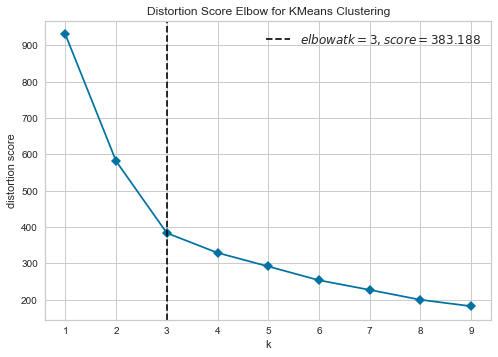

Population


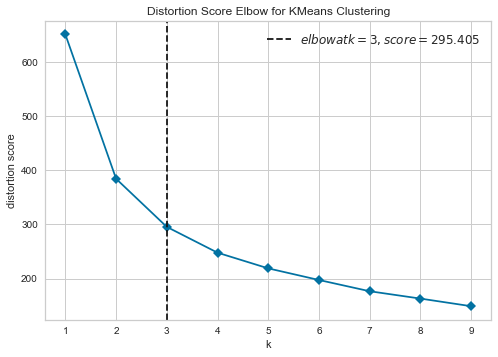

Housing


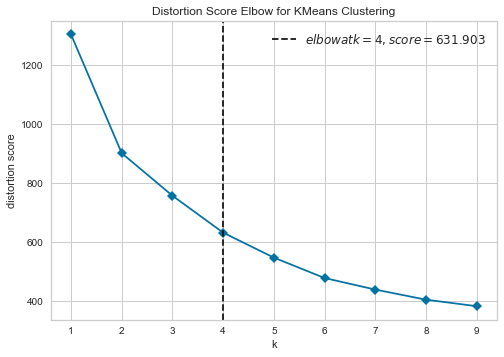

In [16]:
def apply_kmeans(df):
    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    # Get the optimal number of clusters for KMeans using the elbow method
    visualizer = KElbowVisualizer(KMeans(), k=(1,10), metric='distortion', timings=False).fit(X)
    k_cluster = visualizer.elbow_value_
    visualizer.show()
    # Run KMeans model and get the clusters label
    kmeans = KMeans(n_clusters=k_cluster, init='k-means++', n_init=15).fit(X)
    df['Cluster_kmeans'] = kmeans.labels_
    # Get the silhouette score to measure and compare the performance
    silhouette = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
    
    return df, silhouette

silhouette_env = {}
silhouette_pop = {}
silhouette_hous = {}
print('Environment')
df_env, silhouette_env['kmeans'] = apply_kmeans(df_env)
print('Population')
df_pop, silhouette_pop['kmeans'] = apply_kmeans(df_pop)
print('Housing')
df_hous, silhouette_hous['kmeans'] = apply_kmeans(df_hous)

## DBSCAN

Environment


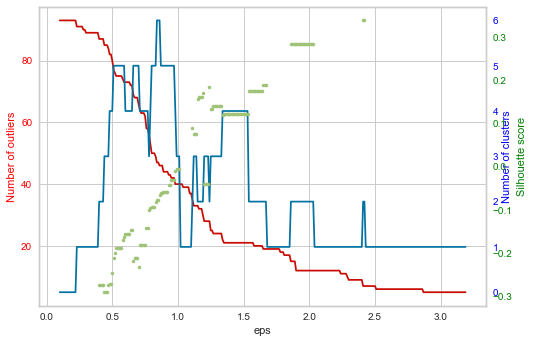

Population


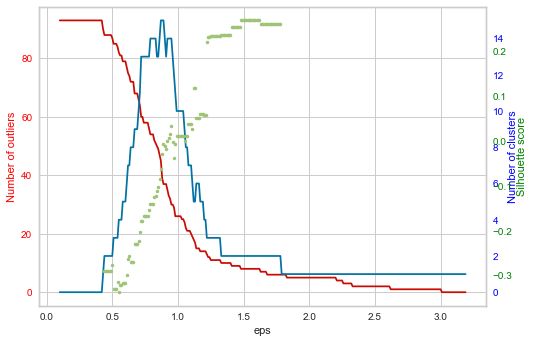

Housing


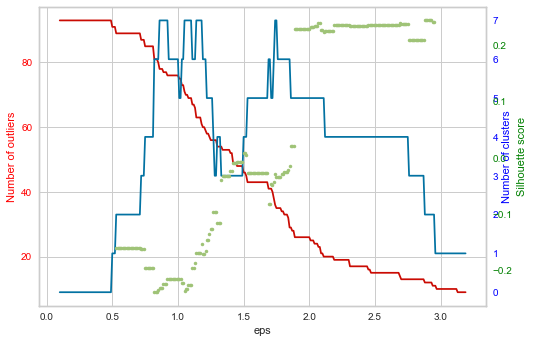

In [17]:
def get_dbscan_parameters(df, min_pts):
    eps_min = 0.1
    eps_max = 3.2
    step = 0.01

    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    
    # Determine the optimal value for eps
    nb_outliers = []
    nb_clusters = []
    silhouette = []
    EPS = np.arange(eps_min, eps_max, step)
    for eps in EPS:
        dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric='euclidean').fit(X)
        unique, counts = np.unique(dbscan.labels_, return_counts=True)
        value_counts = np.asarray((unique, counts)).T
        if -1 in value_counts: # if there are outliers
            nb_outliers.append(value_counts[0][1])
            nb_clusters.append(value_counts.shape[0] - 1)
            if value_counts.shape[0] - 1 > 1: # silhouette score only if there is more than one cluster
                silhouette.append(metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
            else:
                silhouette.append(np.nan) # fake value
        else: # if no outliers
            nb_outliers.append(0)
            nb_clusters.append(value_counts.shape[0])
            if value_counts.shape[0] > 1: # silhouette score only if there is more than one cluster
                silhouette.append(metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'))
            else:
                silhouette.append(np.nan) # fake value
    
    # Plot
    fig, ax1 = plt.subplots()
    # Number of outliers
    ax1.set_xlabel('eps')
    ax1.set_ylabel('Number of outliers', color='red')
    ax1.plot(EPS, nb_outliers, 'r-')
    ax1.tick_params(axis='y', labelcolor='red')
    # Number of clusters
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of clusters', color='blue')
    ax2.plot(EPS, nb_clusters, 'b-')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.grid(False)
    # Silhouette score
    ax3 = ax1.twinx()
    ax3.set_ylabel('Silhouette score', color='green')
    ax3.plot(EPS, silhouette, 'g.')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.grid(False)
    plt.show()
    
    # Get the best value for eps (minimum number of outliers and more than one cluster)
    eps = EPS[[i for i,v in enumerate(nb_clusters) if v > 1][-1]]
    
    return eps


def apply_dbscan(df, eps, min_pts):
    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    # Run DBSCAN model and get the clusters label
    dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric='euclidean').fit(X)
    df['Cluster_DBSCAN'] = dbscan.labels_
    # Get the silhouette score to measure and compare the performance
    silhouette = metrics.silhouette_score(X, dbscan.labels_, metric='euclidean')
    
    return df, silhouette

min_pts = 2
# Get the eps value for each dataset
print('Environment')
eps_env = get_dbscan_parameters(df_env, min_pts)
print('Population')
eps_pop = get_dbscan_parameters(df_pop, min_pts)
print('Housing')
eps_hous = get_dbscan_parameters(df_hous, min_pts)
# Run the DBSCAN model for each dataset
df_env, silhouette_env['DBSCAN'] = apply_dbscan(df_env, eps_env, min_pts)
df_pop, silhouette_pop['DBSCAN'] = apply_dbscan(df_pop, eps_pop, min_pts)
df_hous, silhouette_hous['DBSCAN'] = apply_dbscan(df_hous, eps_hous, min_pts)

## Agglomerative clustering

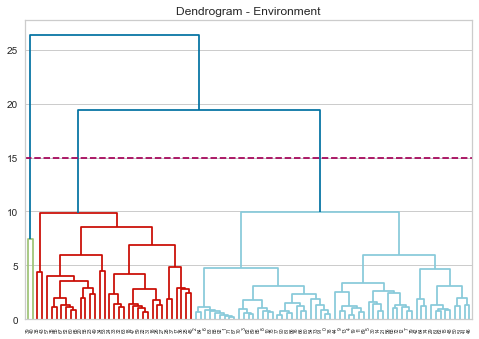

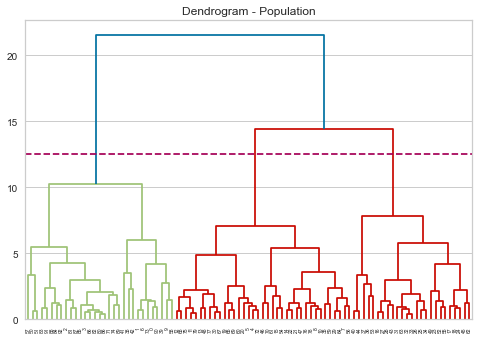

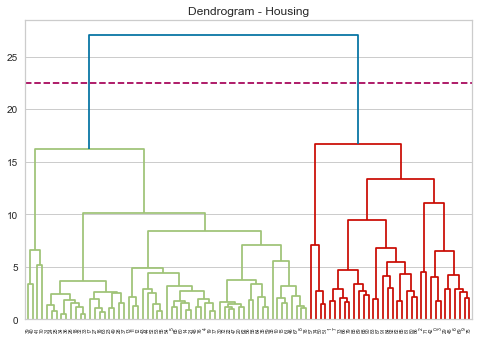

In [18]:
def plot_dendrogram(df, title, select=None):
    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))

    plt.figure()
    plt.grid(axis='x')
    plt.title('Dendrogram - ' + title)  
    dend = shc.dendrogram(shc.linkage(X, method='ward'))
    if select is not None:
        plt.axhline(y=select, color='m', linestyle='--')
    
    
plot_dendrogram(df_env, 'Environment', 15)
plot_dendrogram(df_pop, 'Population', 12.5)
plot_dendrogram(df_hous, 'Housing', 22.5)

In [19]:
def apply_agglomerative(df, n_cluster):
    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    # Run Agglomerative clustering model and get the clusters label
    agglo = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X)
    df['Cluster_Agglomerative'] = agglo.labels_
    # Get the silhouette score to measure and compare the performance
    silhouette = metrics.silhouette_score(X, agglo.labels_, metric='euclidean')
    
    return df, silhouette

df_env, silhouette_env['AgglomerativeClustering'] = apply_agglomerative(df_env, 3)
df_pop, silhouette_pop['AgglomerativeClustering'] = apply_agglomerative(df_pop, 3)
df_hous, silhouette_hous['AgglomerativeClustering'] = apply_agglomerative(df_hous, 2)

# Analysis

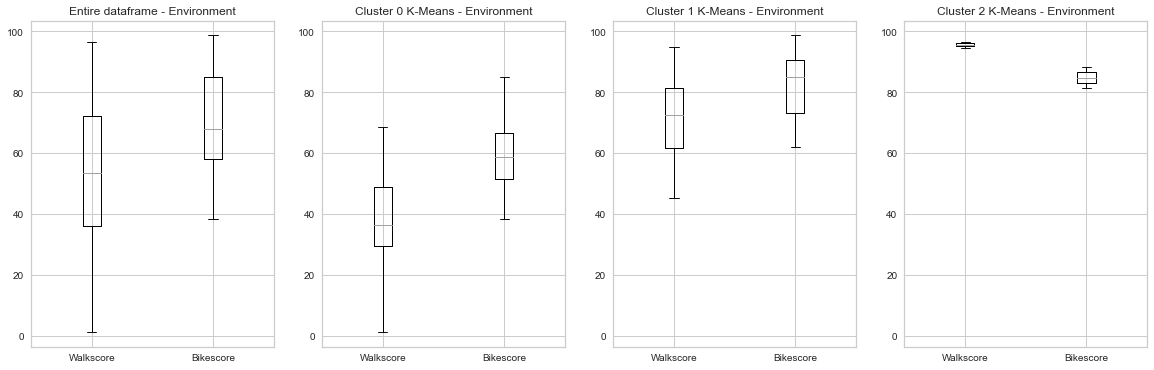

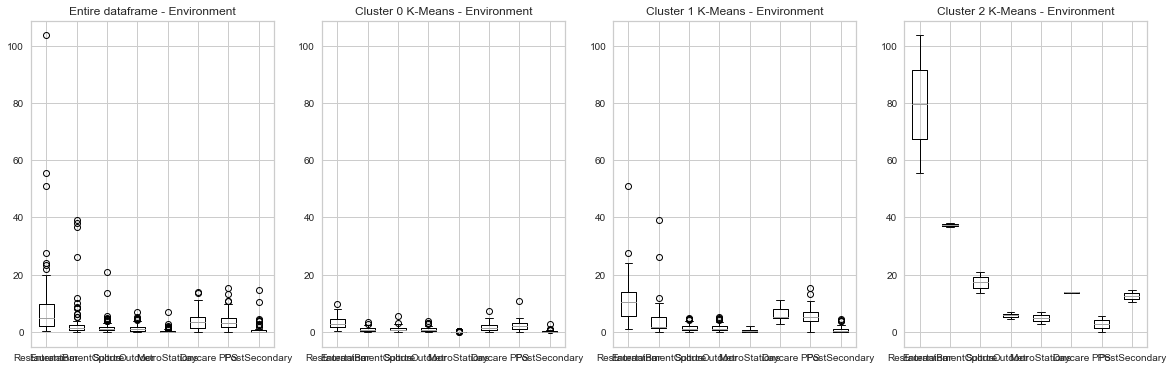

In [80]:
def boxplots(df, columns, method, nb_clusters, title):
    method_columns = {'K-Means': 'Cluster_kmeans',
                      'DBSCAN': 'Cluster_DBSCAN',
                      'Agglomerative Clustering': 'Cluster_Agglomerative'}
    fig = plt.figure(figsize=(20,6))
    ax0 = fig.add_subplot(1, nb_clusters+1, 1)
    df.boxplot(column=columns, ax=ax0)
    ax0.set_title('Entire dataframe - ' + title)
    for i in range(1, nb_clusters+1):
        ax = fig.add_subplot(1, nb_clusters+1, i+1, sharey=ax0)
        df[df[method_columns[method]]==i-1].boxplot(column=columns, ax=ax)
        ax.set_title('Cluster ' + str(i-1) + ' ' + method + ' - ' + title)
        

boxplots(df_env, ['Walkscore', 'Bikescore'], 'K-Means', 3, 'Environment')
columns = ['RestaurantBar', 'EntertainmentCulture', 'Sports', 'Outdoor', 'MetroStations', 'Daycare', 'PPS', 'PostSecondary']
boxplots(df_env, columns, 'K-Means', 3, 'Environment')

In [20]:
df_env.describe()

Walkscore  Bikescore  RestaurantBar  EntertainmentCulture     Sports  \
count  93.000000  93.000000      93.000000             93.000000  93.000000   
mean   53.627647  69.696580       8.570952              3.311081   1.670742   
std    23.713772  15.362559      13.446211              7.203623   2.677133   
min     1.450000  38.500000       0.223881              0.000000   0.000000   
25%    36.088889  58.056604       2.222222              0.578035   0.568182   
50%    53.558824  67.911111       4.726536              1.292407   1.044386   
75%    72.333333  85.081081       9.693053              2.282063   1.761184   
max    96.666667  98.684211     103.522893             39.215686  20.833333   

         Outdoor  MetroStations    Daycare        PPS  PostSecondary  \
count  93.000000      93.000000  93.000000  93.000000      93.000000   
mean    1.386117       0.343267   4.072070   3.647385       0.746011   
std     1.364047       0.862155   3.248243   2.989702       2.029341   
min     0.000000       0.000000   0.000000   0.000000       0.000000   
25%     0.513875       0.000000   1.442704   1.568627       0.000000   
50%     1.012556       0.000000   3.428571   2.977298       0.000000   
75%     1.788109       0.392157   5.341473   4.959939       0.526870   
max     6.944444       6.944444  13.888889  15.247776      14.658109   

       Cluster_kmeans  Cluster_DBSCAN  Cluster_Agglomerative  
count       93.000000       93.000000              93.000000  
mean         0.473118       -0.053763               0.731183  
std          0.543567        0.308065               0.957122  
min          0.000000       -1.000000               0.000000  
25%          0.000000        0.000000               0.000000  
50%          0.000000        0.000000               0.000000  
75%          1.000000        0.000000               2.000000  
max          2.000000        1.000000               2.000000

In [21]:
df_env[df_env['Cluster_kmeans']==0].describe()

Walkscore  Bikescore  RestaurantBar  EntertainmentCulture     Sports  \
count  51.000000  51.000000      51.000000             51.000000  51.000000   
mean   37.170347  59.553658       3.173375              0.969675   1.135408   
std    16.159342  10.743923       2.224725              0.785495   0.985922   
min     1.450000  38.500000       0.223881              0.000000   0.000000   
25%    29.562030  51.619459       1.628470              0.368292   0.565781   
50%    36.576471  58.805556       2.634352              0.704225   0.784314   
75%    48.829365  66.581139       4.469002              1.312183   1.454193   
max    68.612903  85.195122       9.781791              3.349460   5.532139   

         Outdoor  MetroStations    Daycare        PPS  PostSecondary  \
count  51.000000      51.000000  51.000000  51.000000      51.000000   
mean    1.005794       0.051281   1.919059   2.187255       0.194653   
std     0.878886       0.125961   1.488599   1.771941       0.460844   
min     0.000000       0.000000   0.000000   0.000000       0.000000   
25%     0.318247       0.000000   0.813407   1.123885       0.000000   
50%     0.784314       0.000000   1.488649   2.000000       0.000000   
75%     1.313300       0.000000   2.578437   3.030273       0.212982   
max     3.688093       0.513875   7.217848  10.935601       2.941963   

       Cluster_kmeans  Cluster_DBSCAN  Cluster_Agglomerative  
count            51.0       51.000000              51.000000  
mean              0.0       -0.019608               0.039216  
std               0.0        0.140028               0.280056  
min               0.0       -1.000000               0.000000  
25%               0.0        0.000000               0.000000  
50%               0.0        0.000000               0.000000  
75%               0.0        0.000000               0.000000  
max               0.0        0.000000               2.000000

In [22]:
df_env[df_env['Cluster_kmeans']==1].describe()

Walkscore  Bikescore  RestaurantBar  EntertainmentCulture     Sports  \
count  40.000000  40.000000      40.000000             40.000000  40.000000   
mean   72.511784  81.871212      11.904448              4.590935   1.572446   
std    13.469158  10.478333       9.104022              7.285568   1.457463   
min    45.500000  62.200000       1.166667              0.000000   0.000000   
25%    61.680856  73.157670       5.488798              1.300683   0.570586   
50%    72.707983  85.224751      10.323478              1.792156   1.161106   
75%    81.572443  90.607143      14.004199              5.144093   2.010149   
max    95.062500  98.684211      50.980392             39.215686   4.965860   

         Outdoor  MetroStations    Daycare        PPS  PostSecondary  \
count  40.000000      40.000000  40.000000  40.000000      40.000000   
mean    1.652208       0.490391   6.329991   5.554000       0.859424   
std     1.443341       0.577734   2.426825   3.180368       1.292696   
min     0.000000       0.000000   2.785515   0.000000       0.000000   
25%     0.658371       0.000000   4.769583   3.694429       0.000000   
50%     1.138840       0.353862   5.366713   5.185531       0.334881   
75%     1.989045       0.821041   8.099500   6.902060       1.026681   
max     5.249344       1.916933  11.021308  15.247776       4.472843   

       Cluster_kmeans  Cluster_DBSCAN  Cluster_Agglomerative  
count            40.0        40.00000              40.000000  
mean              1.0        -0.05000               1.600000  
std               0.0         0.38895               0.810191  
min               1.0        -1.00000               0.000000  
25%               1.0         0.00000               2.000000  
50%               1.0         0.00000               2.000000  
75%               1.0         0.00000               2.000000  
max               1.0         1.00000               2.000000

In [23]:
df_env[df_env['Cluster_kmeans']==2].describe()

Walkscore  Bikescore  RestaurantBar  EntertainmentCulture     Sports  \
count   2.000000   2.000000       2.000000              2.000000   2.000000   
mean   95.606061  84.848485      79.539224             37.419858  17.287655   
std     1.499923   4.928320      33.918030              1.095430   5.014346   
min    94.545455  81.363636      55.555556             36.645272  13.741977   
25%    95.075758  83.106061      67.547390             37.032565  15.514816   
50%    95.606061  84.848485      79.539224             37.419858  17.287655   
75%    96.136364  86.590909      91.531059             37.807151  19.060494   
max    96.666667  88.333333     103.522893             38.194444  20.833333   

        Outdoor  MetroStations    Daycare       PPS  PostSecondary  \
count  2.000000       2.000000   2.000000  2.000000       2.000000   
mean   5.762552       4.846420  13.815433  2.748395      12.537388   
std    1.671449       2.967055   0.103882  3.886818       2.999152   
min    4.580659       2.748395  13.741977  0.000000      10.416667   
25%    5.171605       3.797408  13.778705  1.374198      11.477027   
50%    5.762552       4.846420  13.815433  2.748395      12.537388   
75%    6.353498       5.895432  13.852161  4.122593      13.597748   
max    6.944444       6.944444  13.888889  5.496791      14.658109   

       Cluster_kmeans  Cluster_DBSCAN  Cluster_Agglomerative  
count             2.0             2.0                    2.0  
mean              2.0            -1.0                    1.0  
std               0.0             0.0                    0.0  
min               2.0            -1.0                    1.0  
25%               2.0            -1.0                    1.0  
50%               2.0            -1.0                    1.0  
75%               2.0            -1.0                    1.0  
max               2.0            -1.0                    1.0

# Tests

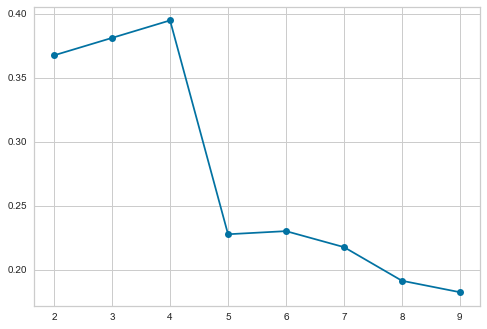

In [97]:
df = df_hous
# Data scaling (drop columns with cluster labels for modelling)
cluster_columns = []
for column in df.columns:
    if 'Cluster' in column:
        cluster_columns.append(column)
X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))

K = range(2,10)
inertias = []
silhouette = []
calinski = []
davies = []
for k in K:
    k_means = KMeans(n_clusters=k).fit(X)
    inertias.append(k_means.inertia_)
    silhouette.append(metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
    calinski.append(metrics.calinski_harabasz_score(X, k_means.labels_))
    davies.append(metrics.davies_bouldin_score(X, k_means.labels_))
# plt.plot(K, inertias, 'ko-')
plt.plot(K, silhouette, 'bo-')
# plt.plot(K, calinski, 'go-')
# plt.plot(K, davies, 'ro-')

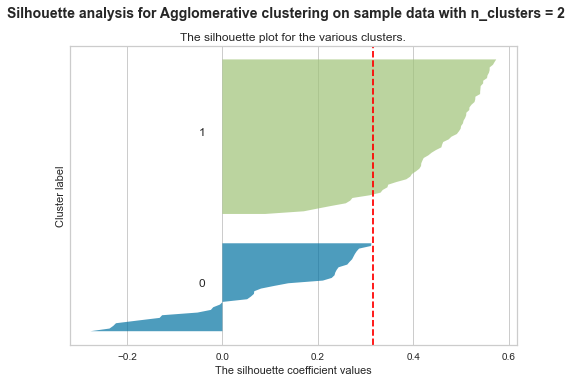

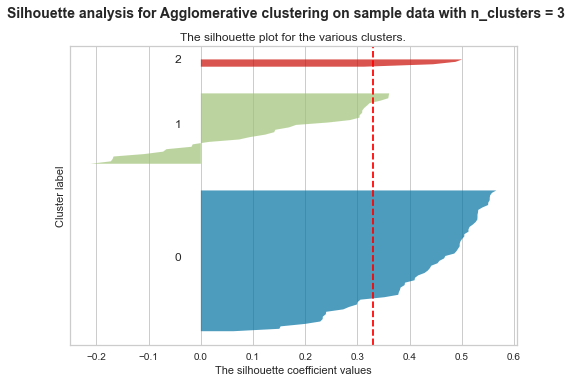

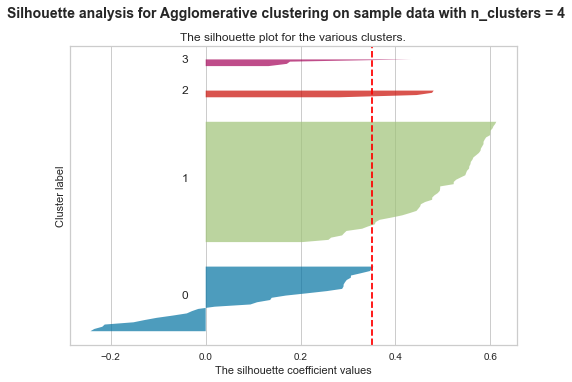

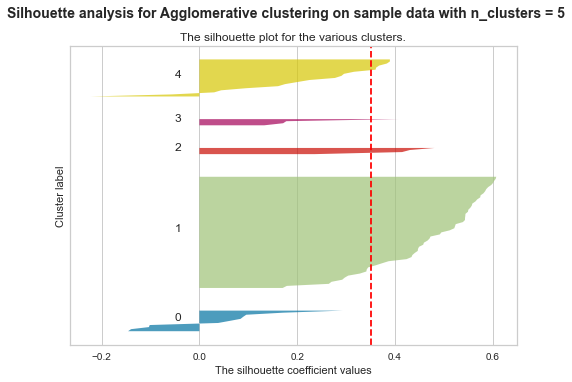

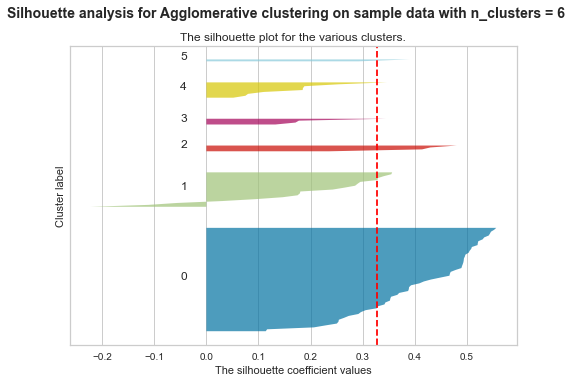

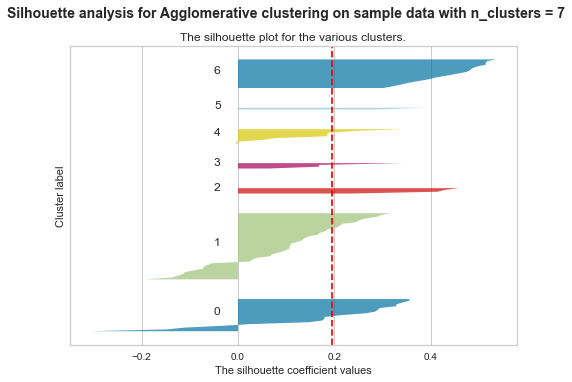

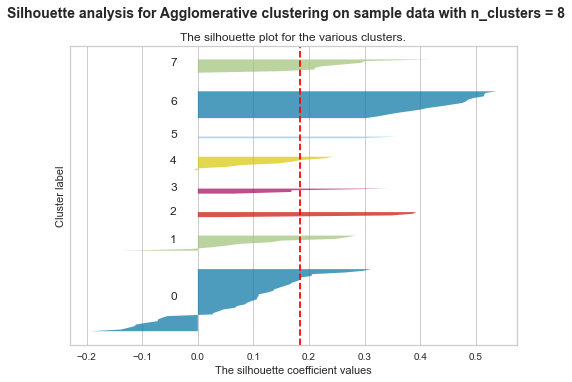

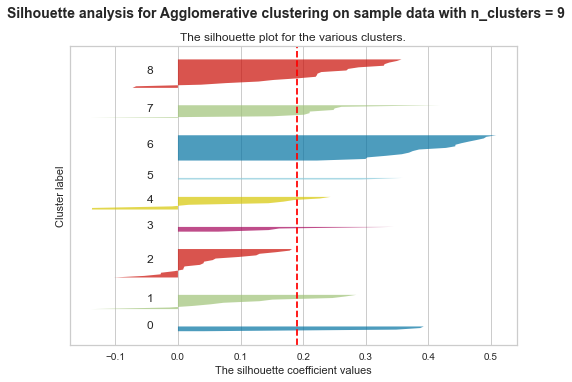

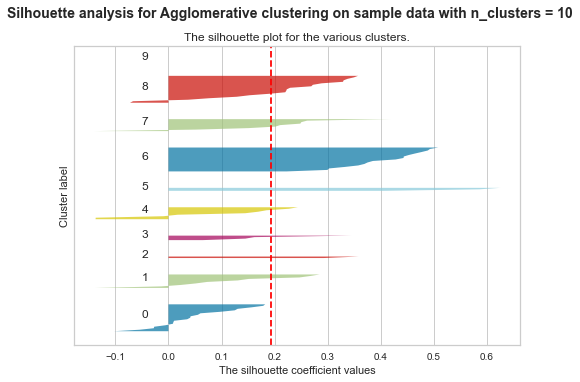

In [93]:
df = df_hous

# Data scaling (drop columns with cluster labels for modelling)
cluster_columns = []
for column in df.columns:
    if 'Cluster' in column:
        cluster_columns.append(column)
X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    
    fig, ax1 = plt.subplots()

    ag = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X)
    labels = ag.labels_

    silhouette_avg = metrics.silhouette_score(X, labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for Agglomerative clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

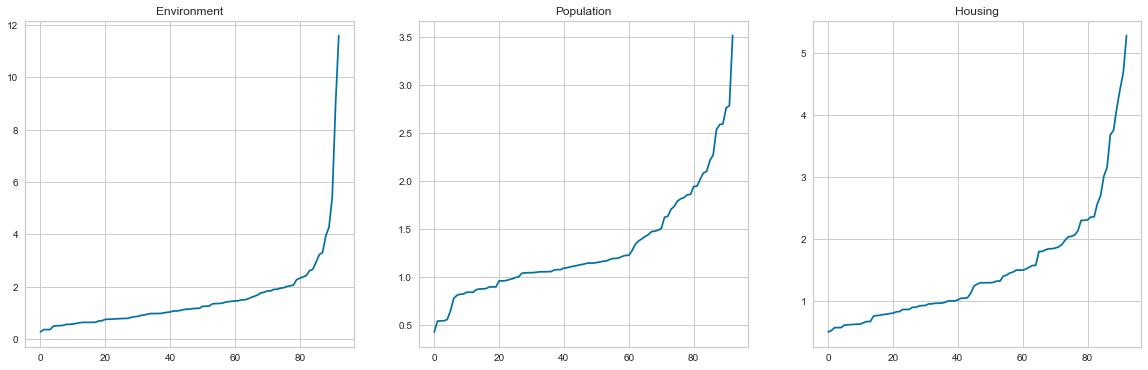

In [462]:
fig = plt.figure(figsize=(20,6))
s = 1
for data in datas:
    k = 3
    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(datas[data][1])
    distances, indices = nbrs.kneighbors(datas[data][1])
#     distance = distances.sum(axis=1)
#     distance = distance / k
    distances = np.sort(distances, axis=0)
    plt.subplot(1, 3, s).set_title(data)
    plt.plot(distances[:,k-1])
    s = s + 1
plt.show()